In [34]:
%pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 KB 2.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Import Section

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from keras import Sequential
from keras.layers import Dense, Dropout, LSTM
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score



2023-10-31 13:36:59.046232: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 13:36:59.098098: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 13:36:59.334278: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 13:36:59.335623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 13:37:00.421905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Loading Dataset

In [26]:
FILE_PATH_TRAINING = "../dataset/UNSW_NB15_training-set.csv"
FILE_PATH_TESTING = "../dataset/UNSW_NB15_testing-set.csv"

df_training =   pd.read_csv(FILE_PATH_TRAINING)
df_testing =    pd.read_csv(FILE_PATH_TESTING)

In [7]:
df_training.shape, df_testing.shape

((175341, 45), (82332, 45))

In [13]:
print(*df_training.columns, sep="\n")

id
dur
proto
service
state
spkts
dpkts
sbytes
dbytes
rate
sttl
dttl
sload
dload
sloss
dloss
sinpkt
dinpkt
sjit
djit
swin
stcpb
dtcpb
dwin
tcprtt
synack
ackdat
smean
dmean
trans_depth
response_body_len
ct_srv_src
ct_state_ttl
ct_dst_ltm
ct_src_dport_ltm
ct_dst_sport_ltm
ct_dst_src_ltm
is_ftp_login
ct_ftp_cmd
ct_flw_http_mthd
ct_src_ltm
ct_srv_dst
is_sm_ips_ports
attack_cat
label


# EDA

In [16]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [17]:
df_training.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,175341.000000,175341.000000,175341.000000,175341.000000,1.753410e+05,1.753410e+05,1.753410e+05,175341.000000,175341.000000,1.753410e+05,...,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000,175341.000000
mean,87671.000000,1.359389,20.298664,18.969591,8.844844e+03,1.492892e+04,9.540619e+04,179.546997,79.609567,7.345403e+07,...,5.383538,4.206255,8.729881,0.014948,0.014948,0.133066,6.955789,9.100758,0.015752,0.680622
std,50616.731112,6.480249,136.887597,110.258271,1.747656e+05,1.436542e+05,1.654010e+05,102.940011,110.506863,1.883574e+08,...,8.047104,5.783585,10.956186,0.126048,0.126048,0.701208,8.321493,10.756952,0.124516,0.466237
min,1.000000,0.000000,1.000000,0.000000,2.800000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,43836.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.278614e+01,62.000000,0.000000,1.305334e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,87671.000000,0.001582,2.000000,2.000000,4.300000e+02,1.640000e+02,3.225807e+03,254.000000,29.000000,8.796748e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,131506.000000,0.668069,12.000000,10.000000,1.418000e+03,1.102000e+03,1.250000e+05,254.000000,252.000000,8.888889e+07,...,5.000000,3.000000,12.000000,0.000000,0.000000,0.000000,9.000000,12.000000,0.000000,1.000000
max,175341.000000,59.999989,9616.000000,10974.000000,1.296523e+07,1.465555e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,...,51.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [14]:
df_training.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


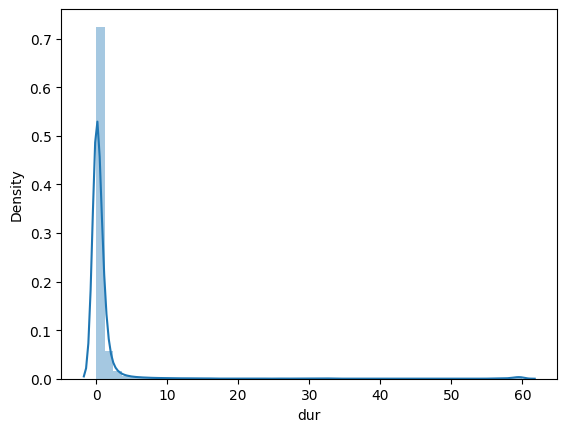

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


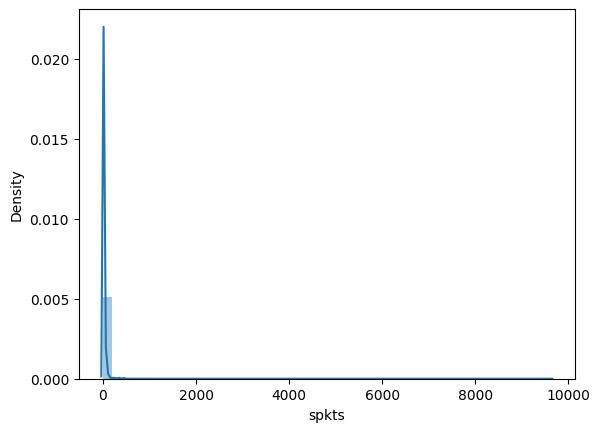

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


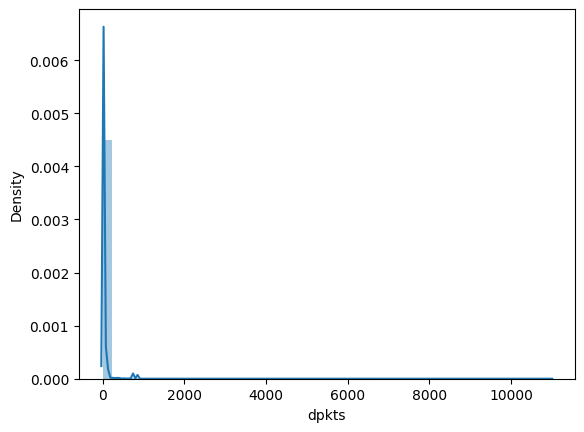

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


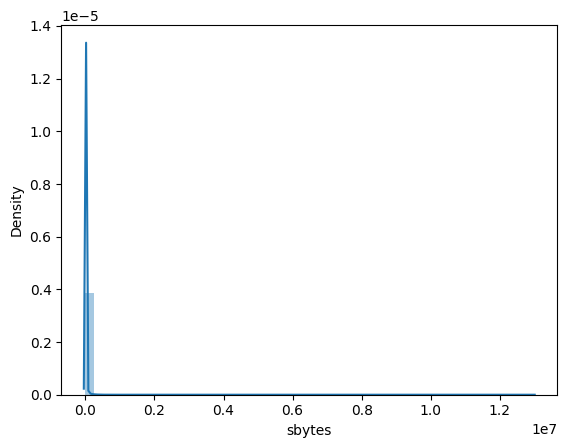

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


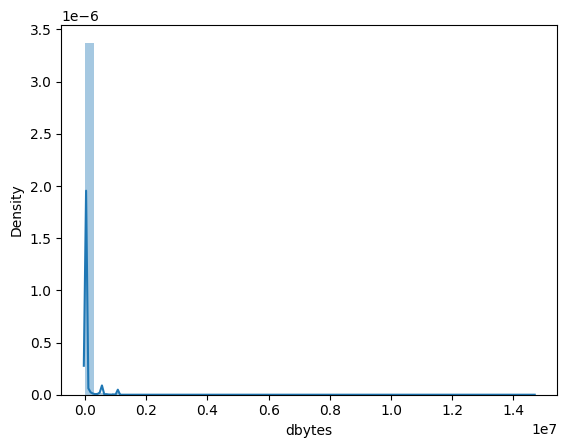

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


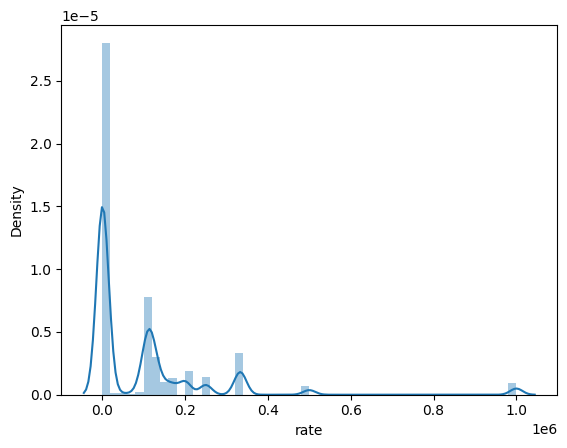

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


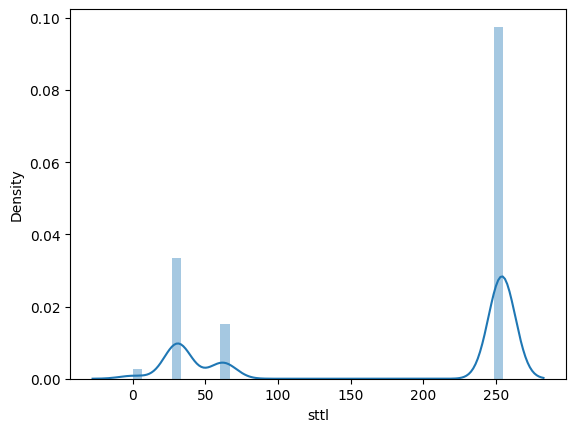

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


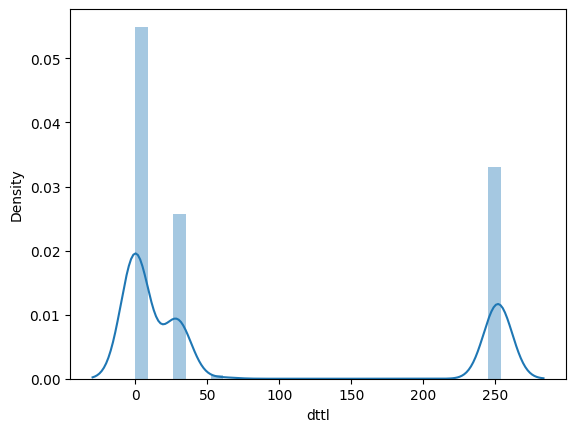

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


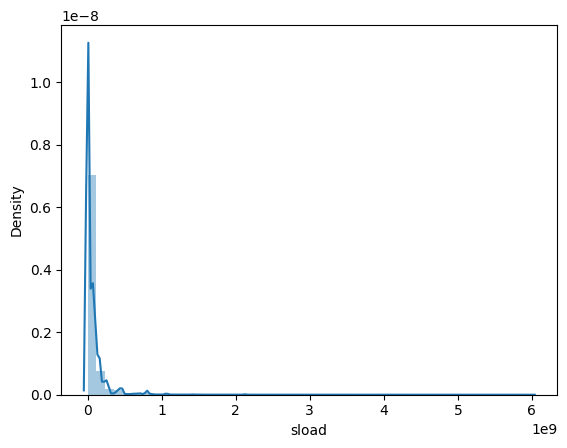

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


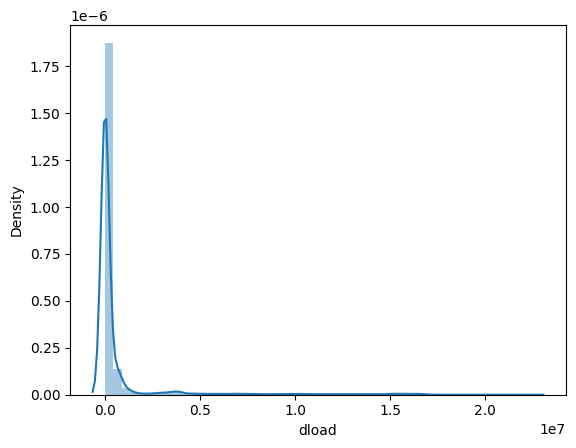

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


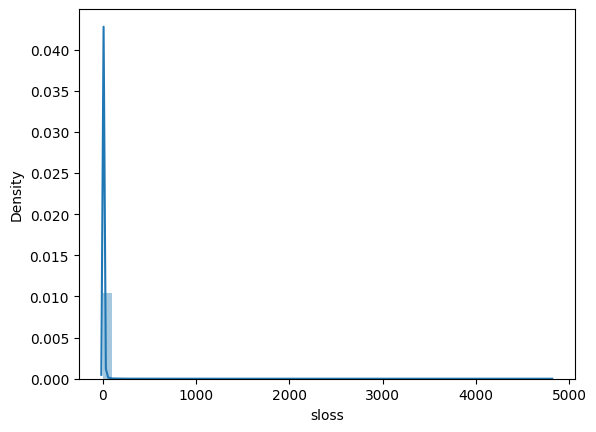

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


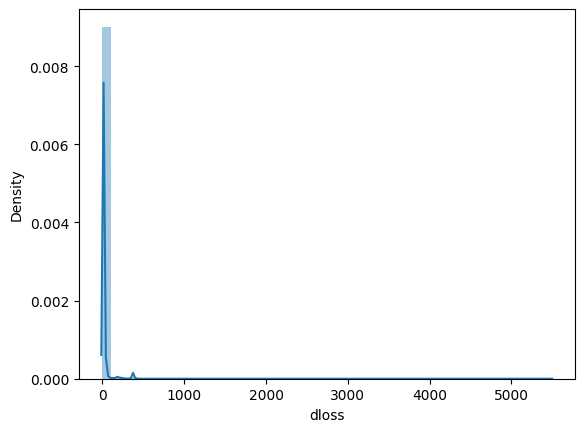

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


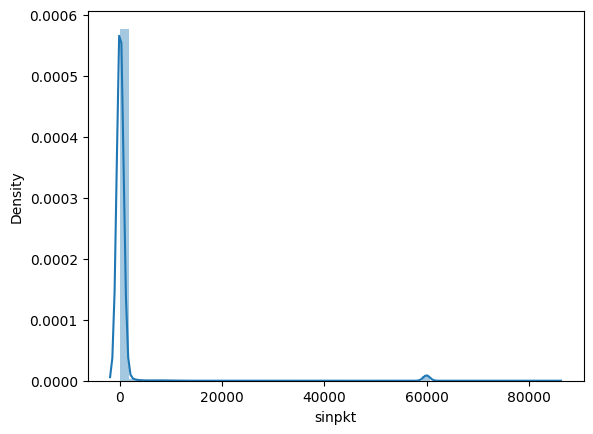

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


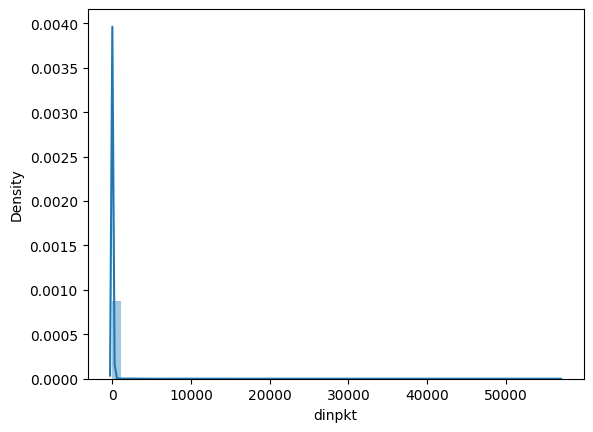

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


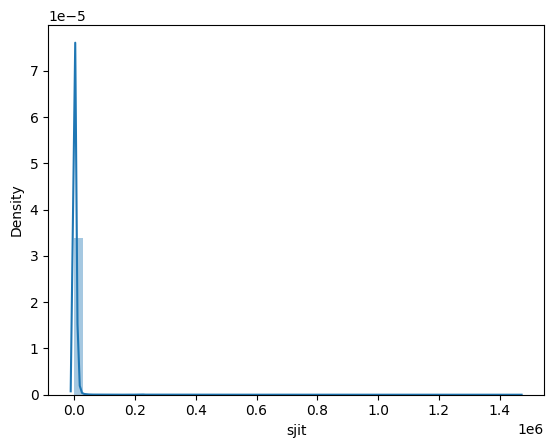

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


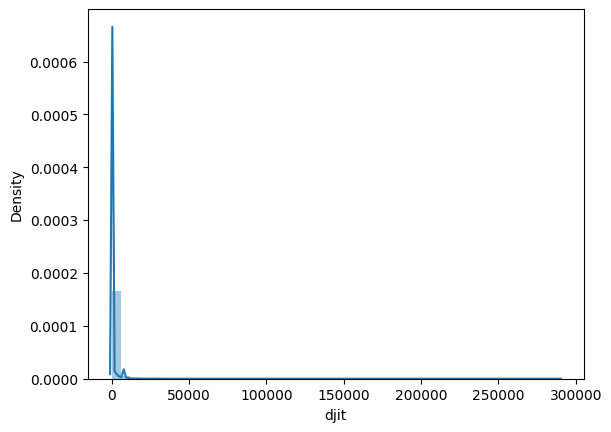

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


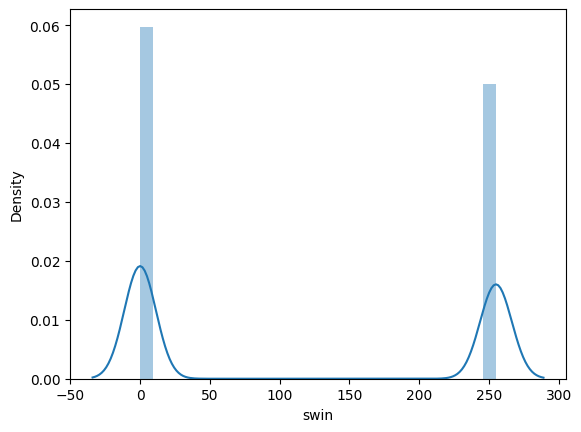

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


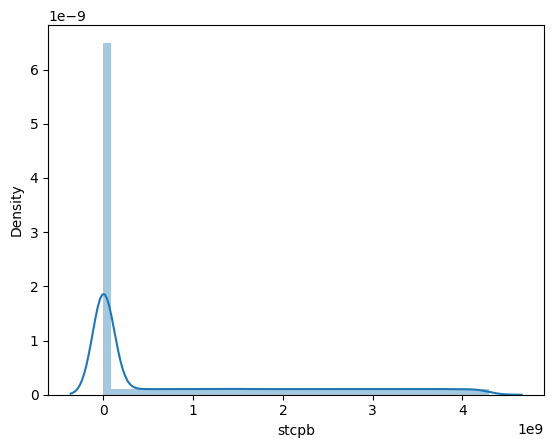

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


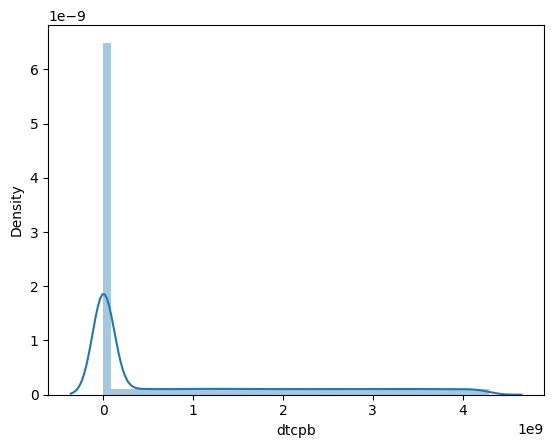

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


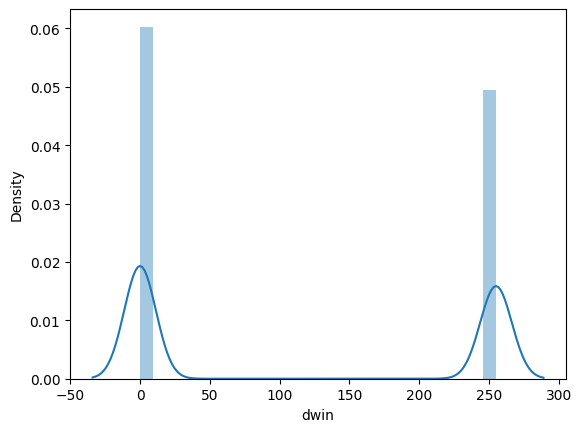

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


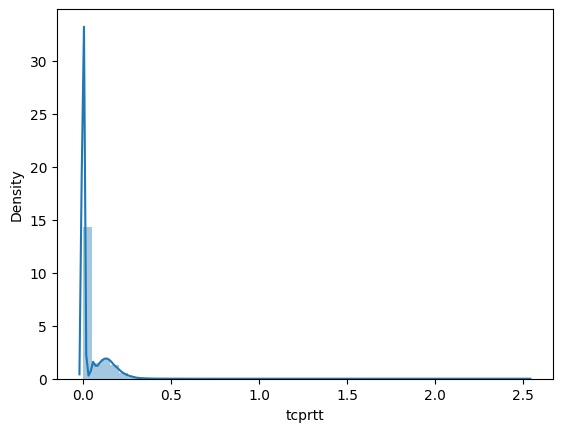

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


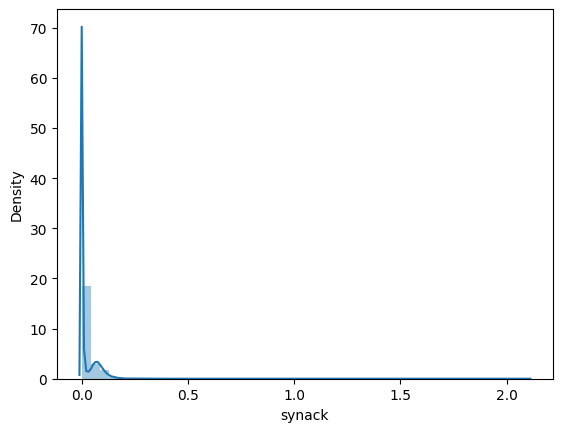

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


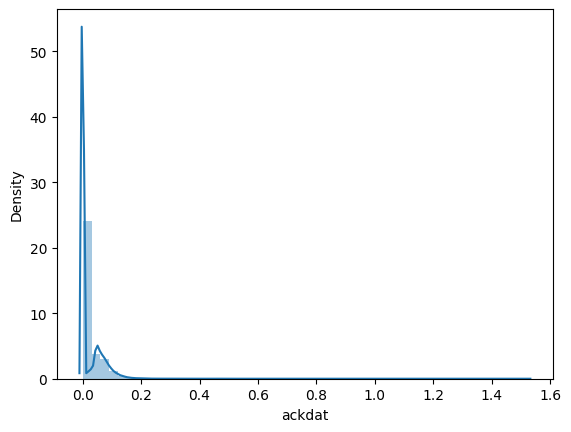

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


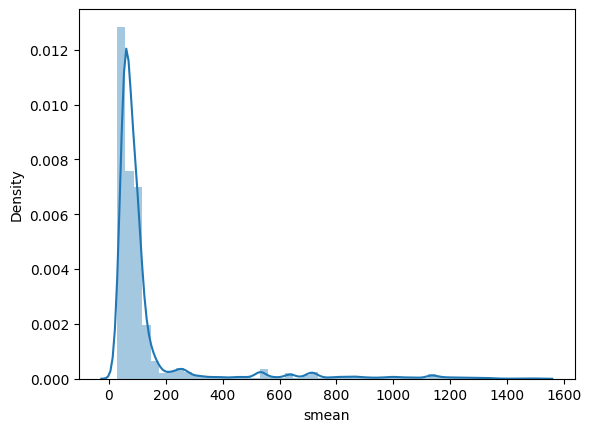

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


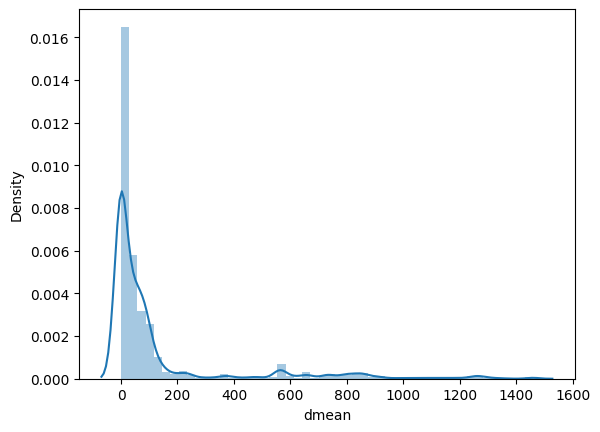

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


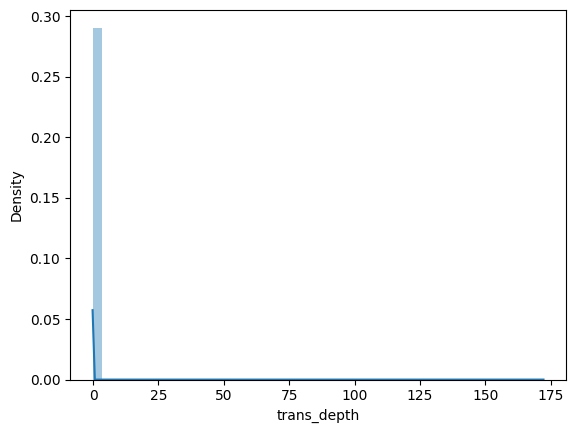

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


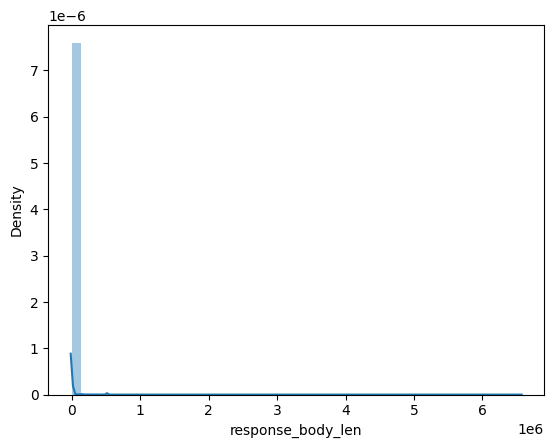

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


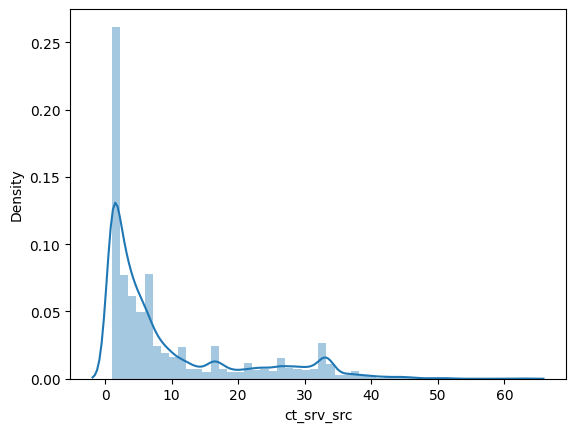

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


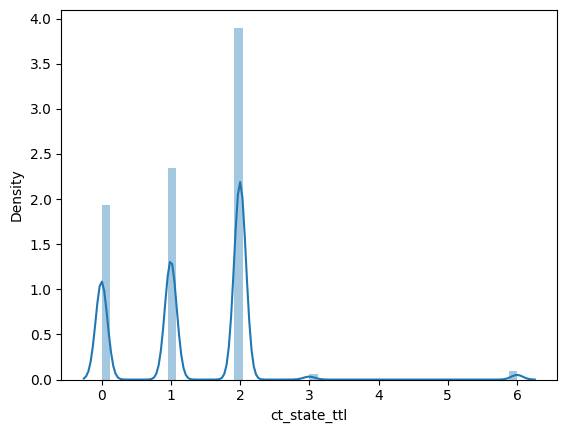

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


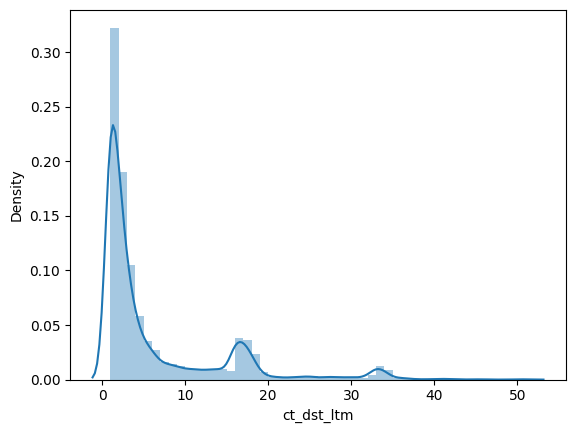

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


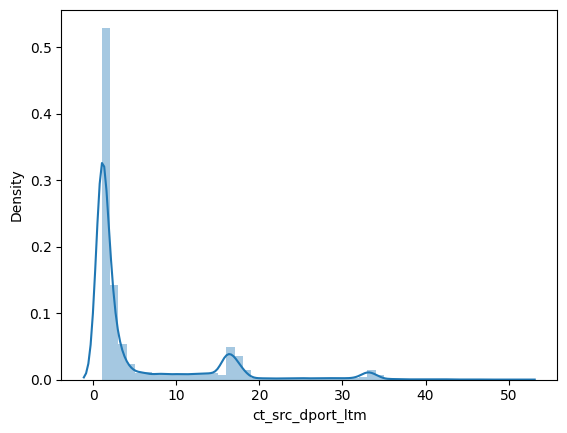

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


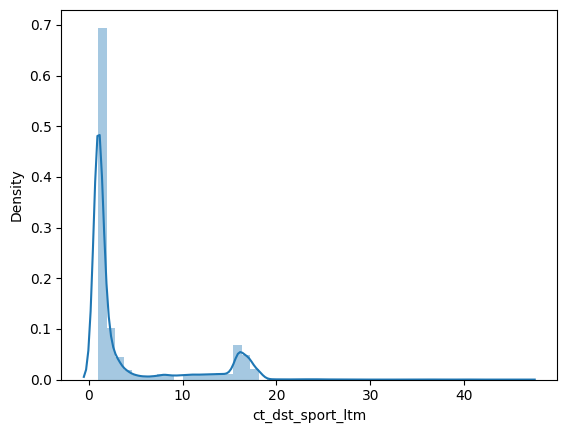

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


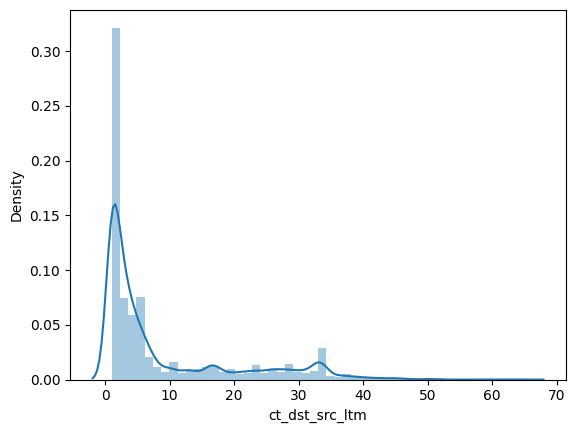

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


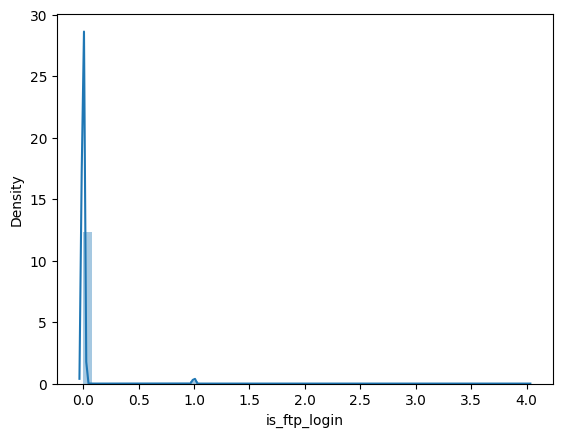

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


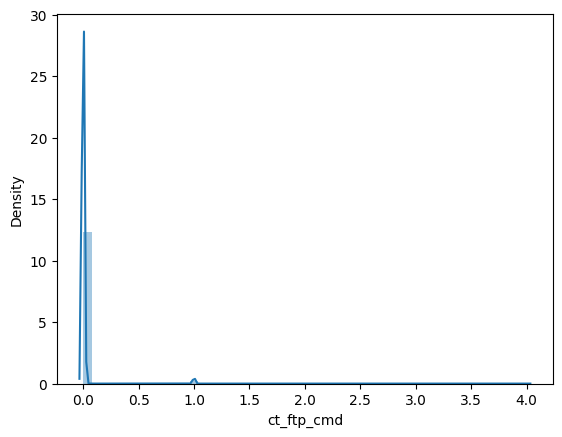

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


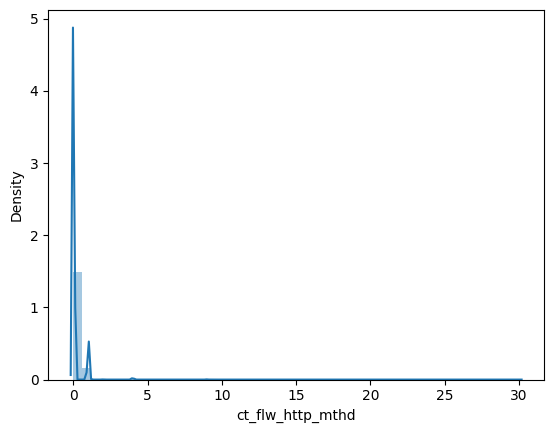

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


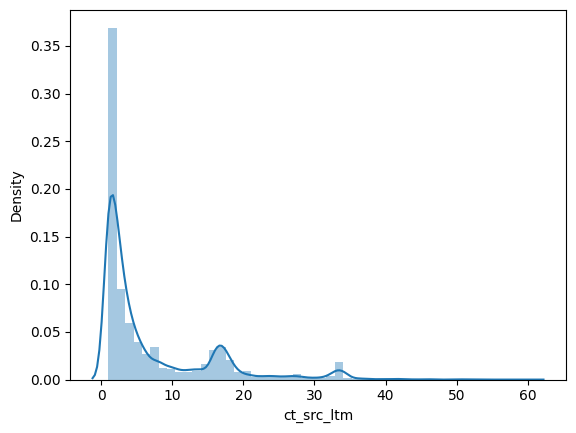

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


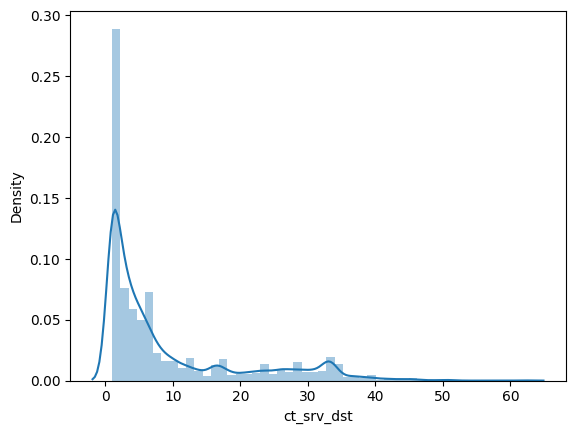

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


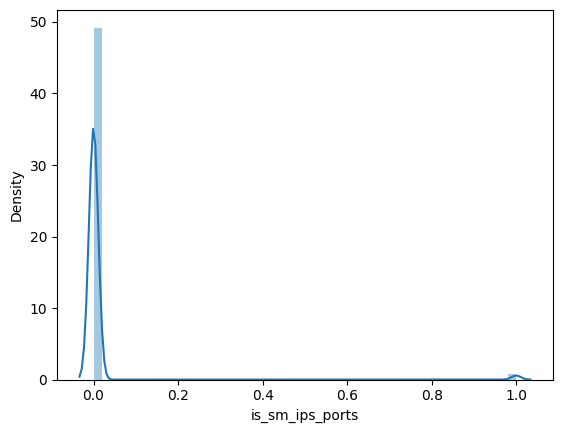

/tmp/ipykernel_872557/2091634008.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


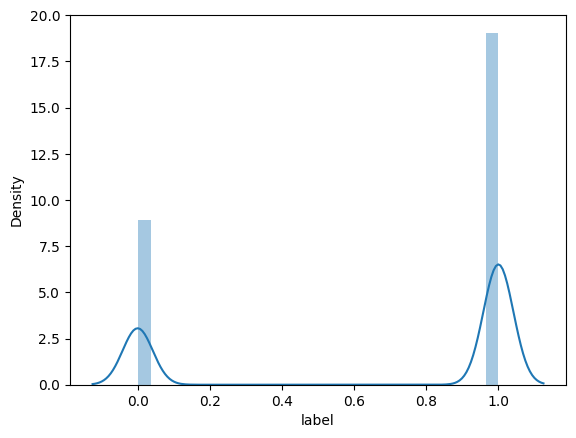

In [20]:
def plot_normal_distribution(df):
    for column in df.columns:
        sns.distplot(df[column])
        plt.show()
        
plot_normal_distribution(df_training)

# Data Preprocessing

## Removing columns

In [19]:
columns_to_remove = ['id','proto','state','service','attack_cat']
df_training.drop(columns_to_remove, axis=1, inplace=True)
df_testing.drop(columns_to_remove, axis=1,inplace=True)


### Remove columns for multi-class classification

In [27]:
columns_to_remove = ['id','proto','state','service','label']
df_training.drop(columns_to_remove, axis=1, inplace=True)
df_testing.drop(columns_to_remove, axis=1,inplace=True)

## Log Modification

In [21]:
for column in df_training.columns:
    if(column !='label'):
        df_training[column] = np.log(df_training[column]+1)
        df_testing[column] = np.log(df_testing[column]+1)
    

## Data Standardization

In [22]:
standard_scaler = StandardScaler()

for column in df_training.columns:
    if column != 'label' and column != 'attack_cat':
        standard_scaler.fit(df_training[column].values.reshape(-1,1))
        df_training[column] = standard_scaler.transform(df_training[column].values.reshape(-1,1))
        df_testing[column] = standard_scaler.transform(df_testing[column].values.reshape(-1,1))

# Train Test Split

## Splitting

In [23]:
X_train = df_training.drop('label', axis=1)
y_train = df_training['label']

X_test = df_testing.drop('label', axis=1)
y_test = df_testing['label']



### Spliting for multiclass classification

In [28]:
X_train = df_training.drop('attack_cat', axis=1)
y_train = df_training['attack_cat']

X_test = df_testing.drop('attack_cat', axis=1)
y_test = df_testing['attack_cat']

### Encoding for multiclass classification

In [29]:
# encode attack_cat using label encoder
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
y_train = labelencoder_y.fit_transform(y_train)
y_test = labelencoder_y.transform(y_test)


# y_train = pd.get_dummies(y_train)
# y_test = pd.get_dummies(y_test)


In [38]:
f={}
for i in range(len(y_train)):
    if y_train[i] not in f:
        f[y_train[i]]=1
    else:
        f[y_train[i]]+=1
print(f)

{6: 56000, 1: 56000, 0: 56000, 4: 56000, 8: 56000, 7: 56000, 3: 56000, 2: 56000, 9: 56000, 5: 56000}


In [31]:
# Calculate class weights to handle class imbalance
class_counts = np.bincount(y_train)
class_weights = dict(enumerate((max(class_counts) / class_counts).astype(float)))
print(class_weights)


{0: 28.0, 1: 32.07331042382589, 2: 4.566210045662101, 3: 1.676998173269847, 4: 3.0796304443466784, 5: 1.4, 6: 1.0, 7: 5.33790868363359, 8: 49.42630185348632, 9: 430.7692307692308}


### Random Oversampling for multiclass classification

In [35]:
from imblearn.over_sampling import RandomOverSampler

# Create a RandomOverSampler object
oversampler = RandomOverSampler()

# Fit and transform the data
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)


In [36]:
X_train, y_train = X_train_oversampled, y_train_oversampled

In [37]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((560000, 39), (560000,), (82332, 39), (82332,))

## Validation split

In [35]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [24]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((65865, 39), (65865,), (16467, 39), (16467,))

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Fit a Random Forest model
rf = RandomForestClassifier(n_estimators=100, n_jobs=50, random_state=42, verbose=1, criterion='entropy',warm_start=True)
rf.fit(X_train, y_train)



[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:    2.0s finished


RandomForestClassifier(criterion='entropy', n_jobs=50, random_state=42,
                       verbose=1, warm_start=True)

In [42]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.


Accuracy: 0.8990310309625245


[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:    0.3s finished


In [210]:

# Get feature importances
feature_importances = rf.feature_importances_

In [211]:
feature_importances

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [212]:
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances}).sort_values('importance', ascending = False)


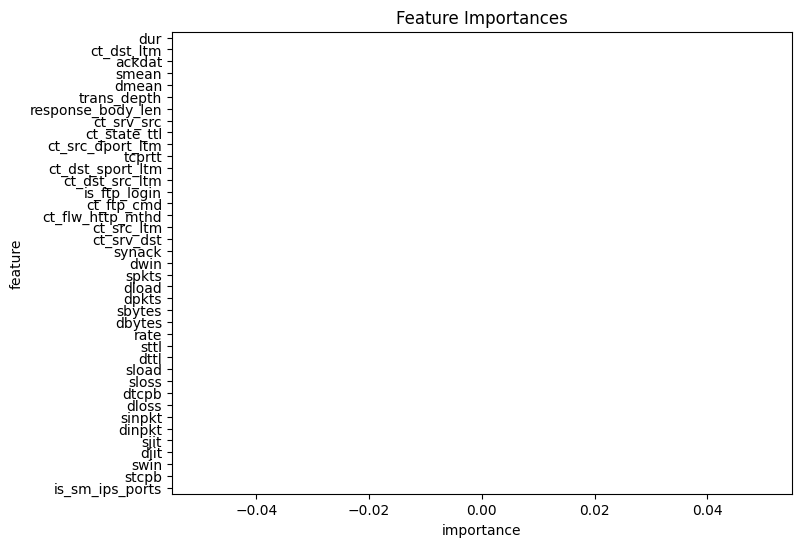

In [213]:
# plot feature importances
plt.figure(figsize = (8, 6))
sns.barplot(x = 'importance', y = 'feature', data = feature_importances)
plt.title('Feature Importances')
plt.show()


In [181]:
# select features with importance greater than 0.01
selected_features = feature_importances[feature_importances['importance'] > 0.01]['feature'].values


In [214]:
# total number of features selected vs total number of features
len(selected_features), X_train.shape[1]

(10, 39)

In [183]:
# new training and testing data with selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]
X_val = X_val[selected_features]

In [230]:
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

((370000, 39), (175341, 39), (16467, 10), (370000,), (175341,), (16467,))

# Model ANN

## Model

In [47]:
def get_model_ann():
  model = Sequential()
  model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def get_model_ann_multiclass():
  model = Sequential()
  model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# model_ann = get_model_ann()  
model_ann = get_model_ann()

## Train

In [48]:
history_ann = model_ann.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(X_val, y_val))


Epoch 1/50
1030/1030 [==============================] - 2s 1ms/step - loss: 0.2087 - accuracy: 0.9116 - val_loss: 0.1465 - val_accuracy: 0.9427
Epoch 2/50
1030/1030 [==============================] - 1s 1ms/step - loss: 0.1339 - accuracy: 0.9475 - val_loss: 0.1234 - val_accuracy: 0.9514
Epoch 3/50
1030/1030 [==============================] - 1s 1ms/step - loss: 0.1194 - accuracy: 0.9529 - val_loss: 0.1128 - val_accuracy: 0.9559
Epoch 4/50
1030/1030 [==============================] - 1s 1ms/step - loss: 0.1132 - accuracy: 0.9549 - val_loss: 0.1076 - val_accuracy: 0.9560
Epoch 5/50
1030/1030 [==============================] - 1s 1ms/step - loss: 0.1086 - accuracy: 0.9569 - val_loss: 0.1117 - val_accuracy: 0.9546
Epoch 6/50
1030/1030 [==============================] - 1s 1ms/step - loss: 0.1064 - accuracy: 0.9581 - val_loss: 0.0990 - val_accuracy: 0.9598
Epoch 7/50
1030/1030 [==============================] - 1s 1ms/step - loss: 0.1031 - accuracy: 0.9583 - val_loss: 0.0994 - val_accuracy:

## Predict

### Binary prediction

In [108]:
y_prediction_ann = model_ann.predict(X_test)


5480/5480 [==============================] - 4s 655us/step


In [97]:
threshold = 0.001
y_prediction_ann = np.where(y_prediction_ann > threshold, 1, 0)

In [98]:
accuracyScore_ann = accuracy_score(y_test, y_prediction_ann)
print("ANN Accuracy: ", accuracyScore_ann)

ANN Accuracy:  0.9291266731682836


### Multi ClassPredicition


In [187]:
y_prediction_ann_multiclass = np.argmax(y_prediction_ann, axis=1)

In [188]:
# calculate accuracy
accuracyScore_ann = accuracy_score(y_test, y_prediction_ann_multiclass)
print("ANN Accuracy with multiclass: ", accuracyScore_ann)

ANN Accuracy with multiclass:  0.6690677023628244


### Plot graph of probability of each class

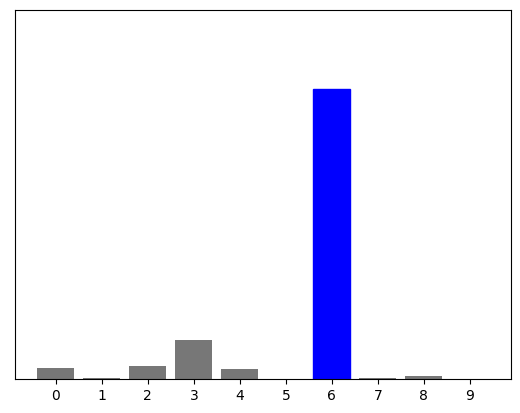

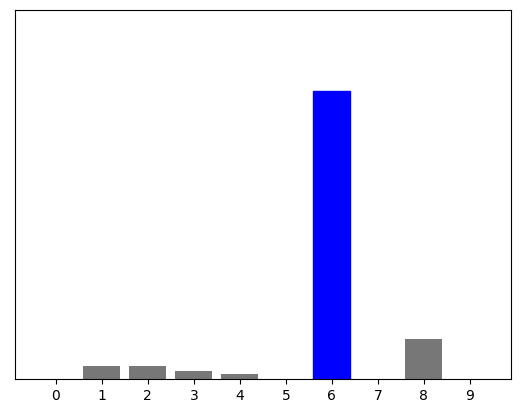

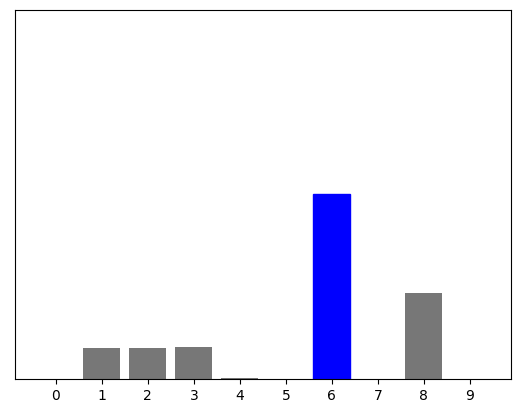

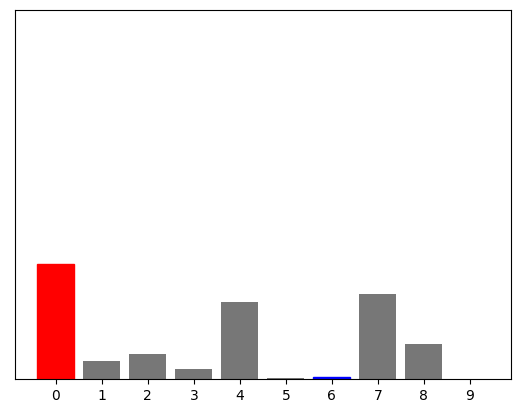

In [189]:
def plot_probabilities(y_prediction_array, true_label,predicted_label=None):
  if predicted_label is None:
    predicted_label = np.argmax(y_prediction_array)
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), y_prediction_array, color="#777777")
  plt.ylim([0, 1])
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

  plt.show()


for i in range(56, 60):
  plot_probabilities(y_prediction_ann[i], y_test[i], y_prediction_ann_multiclass[i])

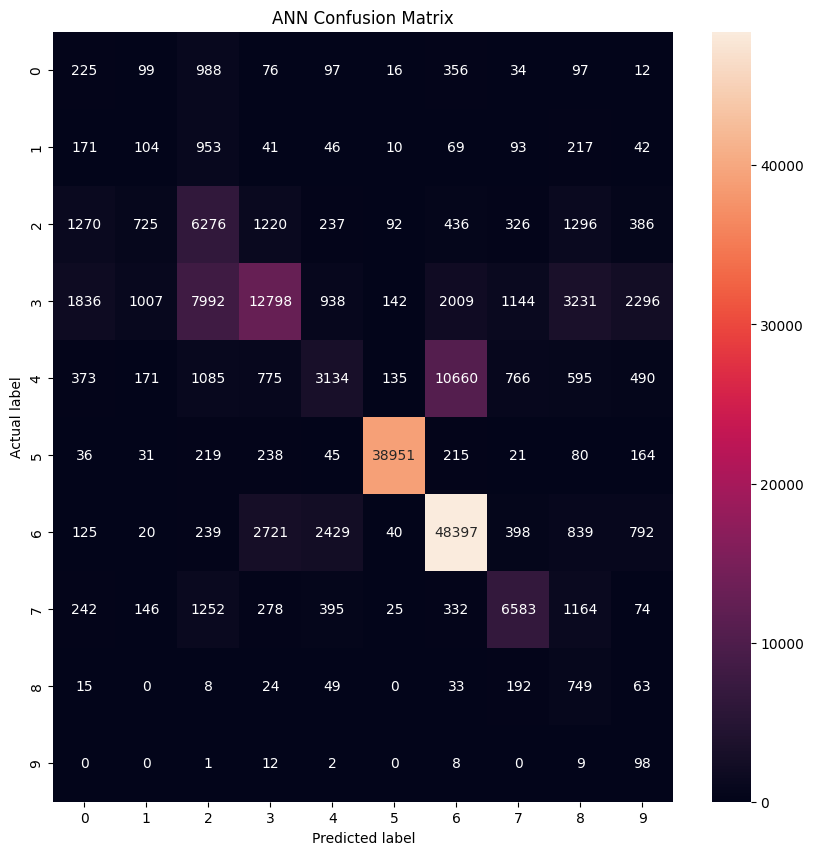

In [190]:
def plot_confusion_matrix(y_test, y_prediction, title):
    cm = confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(y_test, y_prediction_ann_multiclass, "ANN Confusion Matrix")

### Predict for multi-class classification

In [145]:
# save model with time and accuracy
import datetime
model_ann.save('model_ann_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_'+str(accuracyScore_ann)[0:5]+'.h5')

## Confusion Matrix

In [99]:
print(classification_report(y_test, y_prediction_ann))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88     56000
           1       0.91      0.99      0.95    119341

    accuracy                           0.93    175341
   macro avg       0.95      0.89      0.91    175341
weighted avg       0.93      0.93      0.93    175341



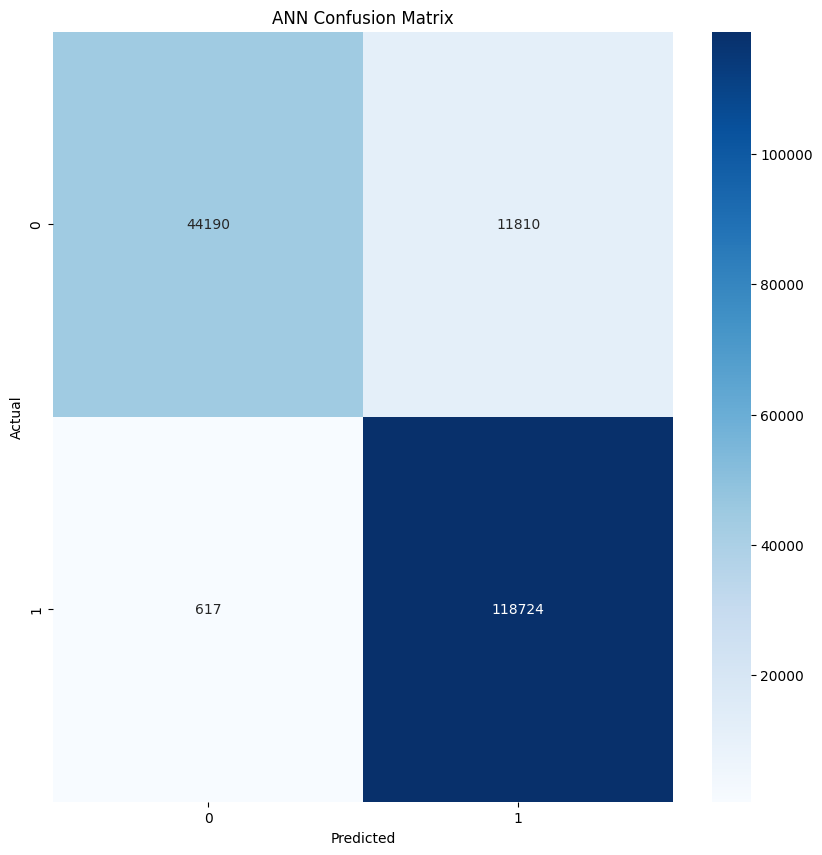

In [100]:
## give confusion matrix
cm_ann = confusion_matrix(y_test, y_prediction_ann)
##  plot it
plt.figure(figsize=(10,10))
plt.title('ANN Confusion Matrix')
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Roc Curve

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_ann)
roc_auc = auc(fpr, tpr)


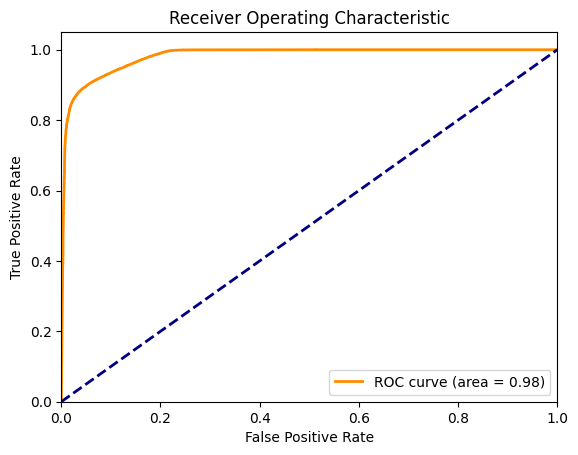

AUC Score: 0.9198574638161714


In [110]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc_score)


# Random Forest

In [39]:

rf = RandomForestClassifier(n_estimators=100, n_jobs=50, random_state=42, verbose=1, criterion='entropy',warm_start=True)

rf.fit(X_train, y_train)

[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:   24.9s finished


RandomForestClassifier(criterion='entropy', n_jobs=50, random_state=42,
                       verbose=1, warm_start=True)

In [40]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.


Accuracy: 0.7253437302628383


[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:    0.5s finished


# XGBoost

In [41]:
# write code for xgboost
xgb = XGBClassifier(n_estimators=100, n_jobs=50, random_state=42, verbose=1, criterion='entropy',warm_start=True)
xgb.fit(X_train, y_train)


[13:57:50] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion", "verbose", "warm_start" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, criterion='entropy',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=50, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [42]:
#predict
y_pred = xgb.predict(X_test)


In [43]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6873755040567459
